<a href="https://colab.research.google.com/github/solayman-cs/ICH/blob/main/PhysioNet_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
os.getcwd()

'/content'

In [ ]:
%cd /content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0

/content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0


In [ ]:
diag_path = 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(diag_path)
df_diag.shape

(2501, 9)

In [ ]:
def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage
0,49,1,0,0,0,0,0,0,0
1,49,2,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,0,0
3,49,4,0,0,0,0,0,0,0
4,49,5,0,0,0,0,0,0,0


In [ ]:
# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)



df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,1,0,0,0,0,0,0,0,1_HGE_Seg.jpg,49_1_HGE_Seg.jpg,1.jpg,49_1.jpg
1,49,2,0,0,0,0,0,0,0,2_HGE_Seg.jpg,49_2_HGE_Seg.jpg,2.jpg,49_2.jpg
2,49,3,0,0,0,0,0,0,0,3_HGE_Seg.jpg,49_3_HGE_Seg.jpg,3.jpg,49_3.jpg
3,49,4,0,0,0,0,0,0,0,4_HGE_Seg.jpg,49_4_HGE_Seg.jpg,4.jpg,49_4.jpg
4,49,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,49_5_HGE_Seg.jpg,5.jpg,49_5.jpg


**Image Folder**

In [ ]:
path = 'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [ ]:
# create a new mask dir
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

FileExistsError: ignored

In [ ]:
# For non blank masks i.e. masks showing intracranial hemorrhage

for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 1]
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # Source path to mask.
        # All masks are in the brain folder.
        path = 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(mask_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
# Check how many masks are in the new folder. (Should be 318)
len(os.listdir('mask_dir'))

318

In [ ]:
# For blank masks i.e. masks without intracranial hemorrhage

blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 0]  # <-- for empty masks change filter here
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # set the destination where the file will be saved
        dst = os.path.join(mask_dir, new_fname)
      
        # save the image
        cv2.imwrite(dst, blank_mask)
        
# Check how many masks are in the new folder. (Should be 2500)
len(os.listdir('mask_dir'))

2501

In [ ]:
# create a new mask dir
brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

In [ ]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(brain_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        

# Check how many images are in the new folder (Should be 2500)
len(os.listdir('brain_image_dir'))

2501

**------------------------------**

In [ ]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)

In [ ]:
print(df_diag.shape)
print(df_test.shape)

(2481, 13)
(20, 13)


In [ ]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(373, 13)


In [ ]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [ ]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix

In [ ]:
# HOW TO DO MULTIPLE AUGMENTATIONS

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


In [ ]:
IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10

In [ ]:
df_train.head(10)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
1960,83,31,0,0,0,0,0,0,0,31_HGE_Seg.jpg,83_31_HGE_Seg.jpg,31.jpg,83_31.jpg
2138,107,17,0,0,0,0,0,0,0,17_HGE_Seg.jpg,107_17_HGE_Seg.jpg,17.jpg,107_17.jpg
1915,71,20,0,0,0,0,1,0,1,20_HGE_Seg.jpg,71_20_HGE_Seg.jpg,20.jpg,71_20.jpg
1926,54,18,0,0,0,0,0,0,0,18_HGE_Seg.jpg,54_18_HGE_Seg.jpg,18.jpg,54_18.jpg
1446,107,13,0,0,0,0,0,0,0,13_HGE_Seg.jpg,107_13_HGE_Seg.jpg,13.jpg,107_13.jpg
2287,120,16,0,0,0,0,0,0,0,16_HGE_Seg.jpg,120_16_HGE_Seg.jpg,16.jpg,120_16.jpg
758,73,16,0,0,0,0,0,0,0,16_HGE_Seg.jpg,73_16_HGE_Seg.jpg,16.jpg,73_16.jpg
1168,52,13,0,0,0,1,0,1,1,13_HGE_Seg.jpg,52_13_HGE_Seg.jpg,13.jpg,52_13.jpg
292,110,11,0,0,0,0,0,0,0,11_HGE_Seg.jpg,110_11_HGE_Seg.jpg,11.jpg,110_11.jpg
983,97,13,0,0,0,0,0,1,0,13_HGE_Seg.jpg,97_13_HGE_Seg.jpg,13.jpg,97_13.jpg


In [ ]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            #lbl_list = list(df['Has_Hemorrhage'])
            
            labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
                #lbl = lbl_list[i]

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                # insert the image into Y_train
                Y_train[i] = aug_mask

                #labels[i] = lbl
                
                              
                
            # Normalize the images
            X_train = X_train/255
            #labels = np.asarray(labels).astype('float32').reshape((-1,1))
            #labels = tf.one_hot(labels, depth=2)

            yield X_train, Y_train

In [ ]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)
print(train_gen)

# run the generator
X_train, Y_train = next(train_gen)

print(len(X_train))

print(X_train.shape)
print(Y_train.shape)
#print(labels.shape)

<generator object train_generator at 0x7fa23a3eb750>
10
(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            #lbl_list = list(df['Has_Hemorrhage'])
            
            val_labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
                #lbl = lbl_list[i]
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                #val_labels[j] = lbl
                
            
            # Normalize the images
            X_val = X_val/255
            #val_labels = np.asarray(val_labels).astype('float32').reshape((-1,1))
            
            yield X_val, Y_val

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)
#print(val_labels.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
            
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            #tf.cast(Y_test, tf.float32)
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test

In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.0 MB/s 


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

import tensorflow as tf

from tensorflow.keras.optimizers import Adam

from keras.losses import binary_crossentropy

from keras.initializers import he_normal 



In [ ]:
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

NameError: ignored

In [ ]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss=dice_loss,
    metrics=[iou_score],
)



filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = model.fit_generator([train_gen,train_gen], steps_per_epoch=train_steps, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


ValueError: ignored

In [ ]:
# Make a prediction

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

 3/20 [===>..........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


20/20 [==============================] - 1s 27ms/step


In [ ]:
preds_test_thresh = (predictions >= 0.5).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


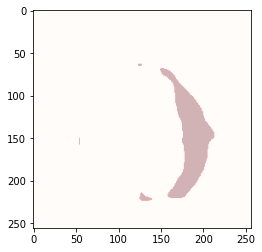

In [ ]:
# This is a predicted mask

indx = 9

mask = preds_test_thresh[indx,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

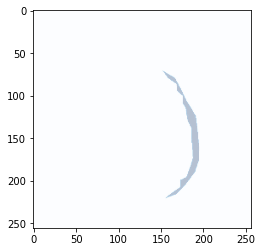

In [ ]:
# This is a true mask

true_mask = Y_test[indx,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

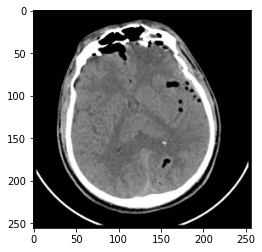

In [ ]:
image = X_test[indx,:,:,:]
plt.imshow(image, cmap='gray')

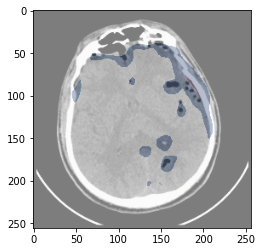

In [ ]:
# This is an overlay of the pred mask, true mask and 
# the x-ray image.

# This is the x-ray image

image = X_test[indx,:,:,:]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)

In [ ]:
intersection = np.logical_and(mask, true_mask)
union = np.logical_or(mask, true_mask)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.054293231284381724


***Segmentation and Classification combined***

In [ ]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator_multiple(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            lbl_list = list(df['Has_Hemorrhage'])
            
            labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
                lbl = lbl_list[i]

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                #aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = image
                
                # insert the image into Y_train
                Y_train[i] = mask

                labels[i] = lbl
                
                              
                
            # Normalize the images
            X_train = X_train/255
            #labels = np.asarray(labels).astype('float32').reshape((-1,1))
            #labels = tf.one_hot(labels, depth=2)
            Y_batch = [Y_train, labels]
            

            yield X_train, Y_batch

In [ ]:
# Test the generator

# initialize
train_gen_mul = train_generator_multiple(batch_size=10)

# run the generator
X_val, Y_batch = next(train_gen_mul)

print(X_val.shape)
print(Y_batch[0].shape)
print(Y_batch[1].shape)


(10, 256, 256, 3)
(10, 256, 256, 1)
(10, 1)


In [ ]:
def val_generator_multiple(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            lbl_list = list(df['Has_Hemorrhage'])
            
            val_labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
                lbl = lbl_list[i]
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                val_labels[j] = lbl
                
            
            # Normalize the images
            X_val = X_val/255
            #val_labels = tf.one_hot(val_labels, depth=2)
            #val_labels = np.asarray(val_labels).astype('float32').reshape((-1,1))
            
           
            Y_val_batch = [Y_val, val_labels]
            print(val_labels.shape)

            yield X_val, Y_val_batch

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=10
# Define the image transformations here
gen_train = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_train(X, y1, y2):
    geny1 = gen_train.flow(X,y1,  batch_size=batch_size,seed=666)
    geny2 = gen_train.flow(X,y2, batch_size=batch_size,seed=666)
    while True:
            y1i = geny1.next()
            y2i = geny2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield y1i[0], [y1i[1], y2i[1]]

# initialize
train_gen_mul = train_generator_multiple(batch_size=10)

# run the generator
X_train, Y_batch = next(train_gen_mul)


# Finally create generator
gen_flow_trn = gen_flow_train(X_train, Y_batch[0], Y_batch[1])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=10
# Define the image transformations here
gen_val = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_val(X, y1, y2):
    geny1 = gen_val.flow(X,y1,  batch_size=batch_size,seed=666)
    geny2 = gen_val.flow(X,y2, batch_size=batch_size,seed=666)
    while True:
            y1i = geny1.next()
            y2i = geny2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            #yield [y1i[0], y1i[1]], [y2i[0], y2i[1]]
            yield y1i[0], [y1i[1], y2i[1]]

# initialize
val_gen_mul = val_generator_multiple(batch_size=10)

# run the generator
X_val, Y_val_batch = next(val_gen_mul)


# Finally create generator
gen_flow_vl = gen_flow_val(X_val, Y_val_batch[0], Y_val_batch[1])

(10,)


In [ ]:
# Segmentation and Binary Classification
# Encoder: efficientnetb0 
# Decoder: Unet


from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)


BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

cls_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

#inpt = model.layers[266].output
print(model.layers[197].output.shape)
print(model.output.shape)

# classif path
x = GlobalAveragePooling2D()(model.layers[197].output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#x = Flatten()(x)
x = Dropout(0.5)(x)
classif_output = Dense(1, activation='sigmoid', name='classif_output')(x)
print(classif_output.shape)


my_model = Model(inputs=model.input, outputs= [model.output, classif_output])



my_model.summary()

(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 1)
Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_204 (ZeroPaddin  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                         

In [ ]:
# Initialize the generators
#train_gen = train_generator(batch_size=BATCH_SIZE)
#val_gen = val_generator(batch_size=BATCH_SIZE)
#train_gen_mul = train_generator_multiple(batch_size=BATCH_SIZE)
#val_gen_mul = val_generator_multiple(batch_size=BATCH_SIZE)

#gn_train = generator_train(batch_size=BATCH_SIZE)
#gn_validation = generator_validation(batch_size=BATCH_SIZE)


#print(train_gen)


# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
my_model.compile(optimizer=optimizer,
              loss={'sigmoid': dice_loss, 'classif_output': 'binary_crossentropy'},
 metrics={'sigmoid': iou_score,
          'classif_output': 'accuracy'})

'''my_model.compile(
    Adam(learning_rate=0.0001),
    loss=[dice_loss],
    metrics=[iou_score, 'accuracy'],
)'''



filepath = "model_cls.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = my_model.fit(gen_flow_trn, steps_per_epoch=train_steps, epochs=40, 
                              validation_data=(X_val, [Y_val_batch[0], Y_val_batch[1]]), validation_steps=val_steps,
                             verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
211/211 [==============================] - 2927s 14s/step - loss: 1.1450 - sigmoid_loss: 0.4904 - classif_output_loss: 0.6546 - sigmoid_iou_score: 0.3477 - classif_output_accuracy: 0.7915 - val_loss: 1.5364 - val_sigmoid_loss: 0.9498 - val_classif_output_loss: 0.5867 - val_sigmoid_iou_score: 0.0336 - val_classif_output_accuracy: 1.0000
Epoch 2/40
 49/211 [=====>........................] - ETA: 36:56 - loss: 0.8977 - sigmoid_loss: 0.2915 - classif_output_loss: 0.6062 - sigmoid_iou_score: 0.5492 - classif_output_accuracy: 0.8000